In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import WhisperProcessor, WhisperForConditionalGeneration

from tqdm import tqdm
import importlib

import audio_utils as audio

In [3]:
dataset = load_from_disk("./tedlium/validation.hf").with_format("torch").select(range(100))

In [4]:
torch.cuda.is_available()

True

In [5]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en", output_attentions=True).to("cuda")
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# model

In [8]:
def inference(audio_tensor, model, processor, is_longform=False, skip_special_tokens=False):
    if not is_longform:
        inputs = processor(audio_tensor, return_tensors="pt", sampling_rate=16_000)
        input_features = inputs.input_features.to(model.device)
        res = model.generate(input_features, output_attentions=True, return_dict_in_generate=True)
        decoded = processor.batch_decode(res["sequences"], skip_special_tokens=skip_special_tokens)
        return (decoded[0], res.encoder_attentions, res.decoder_attentions, res.cross_attentions)
    else:
        inputs = processor(audio_tensor, return_tensors="pt", truncation=False, padding="longest", return_attention_mask=True, sampling_rate=16_000)
        input_features = inputs.to(model.device)
        res = model.generate(**input_features, output_attentions=True, return_dict_in_generate=True)
        decoded = processor.batch_decode(res, skip_special_tokens=skip_special_tokens)
        return (decoded[0], None, None, None)

In [16]:
print(dataset[5], dataset[5]["audio"].shape[0] / 16000)

{'audio': tensor([ 0.0221,  0.0246,  0.0284,  ...,  0.0018,  0.0044, -0.0007]), 'text': 'this question was so compelling that we decided to explore the answer by building siftables'} 5.38


In [17]:
example = dataset[5]["audio"]

In [18]:
audio.play_audio(example)

In [19]:
res, e_attns, d_attns, c_attns = inference(example, model, processor, skip_special_tokens=True)

/home/jovyan/libs/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
WhisperModel is using WhisperSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [20]:
res.strip().split()

['This',
 'question',
 'was',
 'so',
 'compelling',
 'that',
 'we',
 'decided',
 'to',
 'explore',
 'the',
 'answer',
 'by',
 'building',
 'sytables.']

In [21]:
def plot_attns(attns, rows, cols, figsize=(30, 10), filename=None):
    attns = [a.cpu().squeeze(0) for a in attns]
    blocks = len(attns)
    heads = attns[0].size(0)
    assert rows * cols == blocks * heads
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    pbar = tqdm(range(blocks * heads), leave=True, ncols=0)
    
    for idx in pbar:
        i, j = idx // cols, idx % cols
        x, y = idx // heads, idx % heads
        sns.heatmap(attns[x][y,:,:], cmap="viridis", ax=ax[i][j])
        ax[i][j].set_title(f"Block {x + 1} Head {y + 1}")
        pbar.refresh()

    # plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

# Aggregation

In [ ]:
def process(e_attns, d_attns, c_attns, truncated=True):
    encoder_limit = int(example.size(0) / 16000 * 50) + 1
    
    # process e_attns
    if truncated:
        e_attns = e_attns[:, :, :encoder_limit, :encoder_limit]
    res_e = torch.stack(e_attns).squeeze()
    
    # process d_attns
    longest = d_attns[-1][0].size(3) # longest attention tensor length
    d_attns_stacked = [F.pad(torch.stack(d).squeeze(), (0, longest - d[0].size(3), 0, 0), "constant", 0.0) for d in d_attns[1:]]
    res_d = d_attns_stacked
    
    return res_e, res_d, res_c

# Encoder Attentions

In [269]:
list(map(lambda x: x.size(), e_attns))

[torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500])]

In [24]:
encoder_limit = int(example.size(0) / 16000 * 50) + 1
encoder_limit

270

In [ ]:
plot_attns(torch.stack(e_attns), 8, 3, figsize=(30, 80), filename="graphs/tinyen_encoder.png")

In [ ]:
plot_attns(torch.stack(e_attns).squeeze()[:, :, :encoder_limit, :encoder_limit], 8, 3, figsize=(30, 80), filename="graphs/tinyen_encoder_truncated.png")

# Decoder Attentions

In [ ]:
list(map(lambda x: tuple(map(lambda y: y.size(), x)), d_attns))

In [210]:
d_attns_stacked = [F.pad(torch.stack(d).squeeze(), (0, d_attns[-1][-1].size(3) - d[-1].size(3), 0, 0), "constant", 0.0) for d in d_attns[1:]]

In [214]:
d_attns_nett = torch.stack(d_attns_stacked).permute(1, 2, 0, 3)
d_attns_nett.shape

torch.Size([4, 6, 18, 20])

In [ ]:
plot_attns(d_attns_nett, 6, 4, figsize=(40, 60), filename="graphs/tinyen_decoder.png")

# Cross Attentions

In [22]:
c_attns_stacked = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)

In [ ]:
plot_attns(c_attns_stacked, 8, 3, figsize=(30, 80), filename="graphs/tinyen_cross.png")

100% 24/24 [00:29<00:00,  1.22s/it]


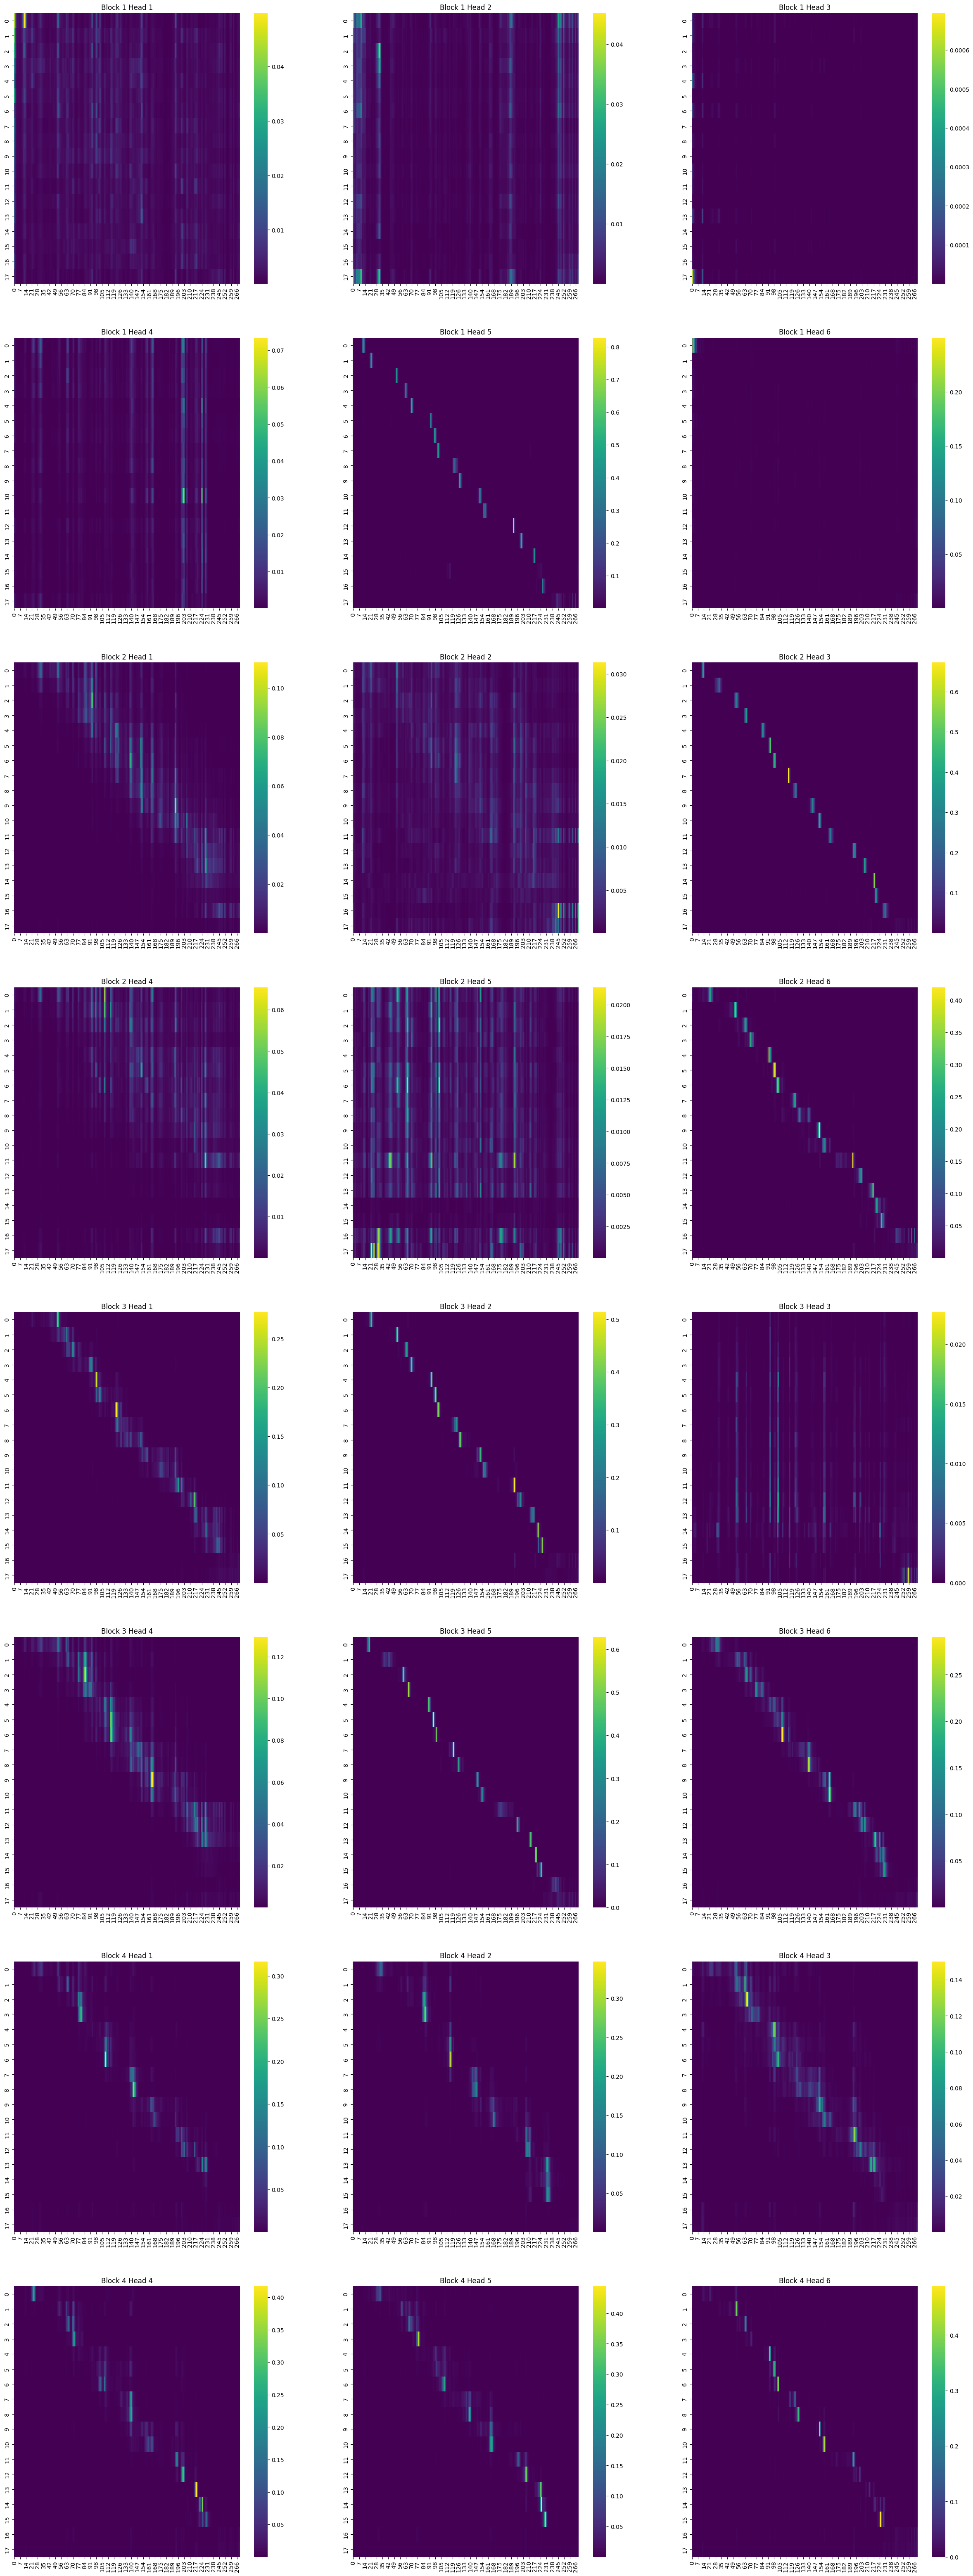

In [25]:
c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit]
plot_attns(c_attns_stacked_cutoff, 8, 3, figsize=(30, 80), filename=None)

In [13]:
c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit]

NameError: name 'c_attns' is not defined